In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

In [2]:
df_need = pd.read_csv('need.csv')

In [3]:
# 비율 feature 생성
grouped = df_need.groupby(['서비스_업종_코드', '서비스_업종_코드_명']).sum(numeric_only=True).reset_index()

grouped['weekday_ratio'] = grouped['주중_매출_금액'] / grouped['당월_매출_금액']
grouped['weekend_ratio'] = grouped['주말_매출_금액'] / grouped['당월_매출_금액']
grouped['male_ratio'] = grouped['남성_매출_금액'] / grouped['당월_매출_금액']
grouped['female_ratio'] = grouped['여성_매출_금액'] / grouped['당월_매출_금액']
grouped['unknown_ratio'] = grouped['법인카드_외국인_신원미상_금액'] / grouped['당월_매출_금액']

for age in ['10', '20', '30', '40', '50', '60_이상']:
    grouped[f'{age}s_ratio'] = grouped[f'연령대_{age}_매출_금액'] / grouped['당월_매출_금액']

In [4]:
# 클러스터링에 사용할 feature 선택
features = grouped[
    ['weekday_ratio', 'weekend_ratio', 'male_ratio', 'female_ratio', 'unknown_ratio',
     '10s_ratio', '20s_ratio', '30s_ratio', '40s_ratio', '50s_ratio', '60_이상s_ratio']
]

In [5]:
# 표준화 (StandardScaler)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [6]:
# linkage 행렬 생성 (ward 방식)
Z = linkage(scaled_features, method='ward')

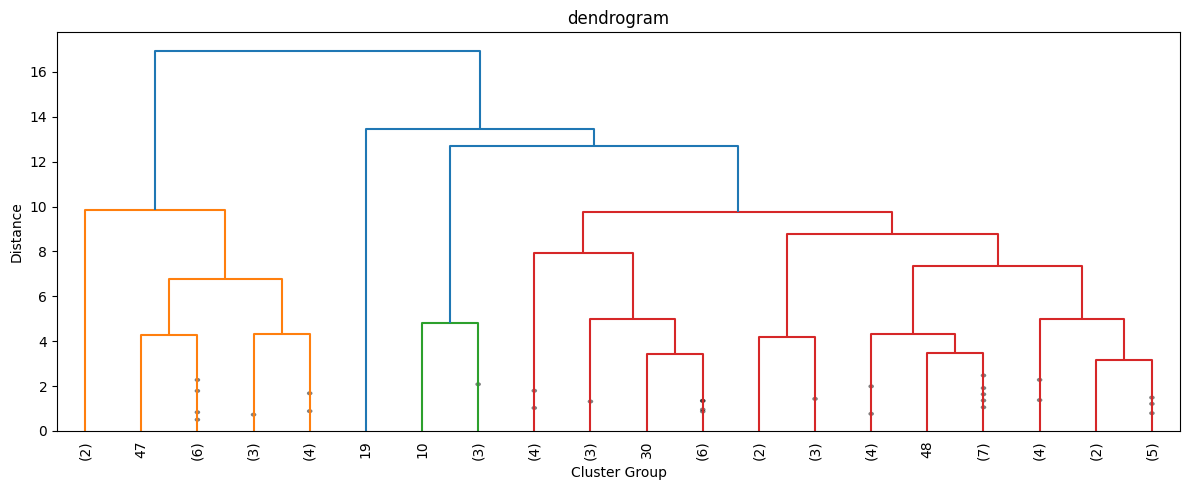

In [7]:
# 덴드로그램 시각화
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='lastp', p=20, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.title('dendrogram')
plt.xlabel('Cluster Group')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import silhouette_score
import numpy as np

In [9]:
cluster_range = range(2, 11)
silhouette_scores = []
Inertia = []

for k in cluster_range:
    labels = fcluster(Z, t=k, criterion='maxclust')
    silhouette_scores.append(silhouette_score(scaled_features, labels))

    centroids = np.array([scaled_features[labels == i].mean(axis=0) for i in np.unique(labels)])
    wss = sum(((scaled_features[labels == i] - centroid) ** 2).sum() for i, centroid in enumerate(centroids, start=1))
    Inertia.append(wss)

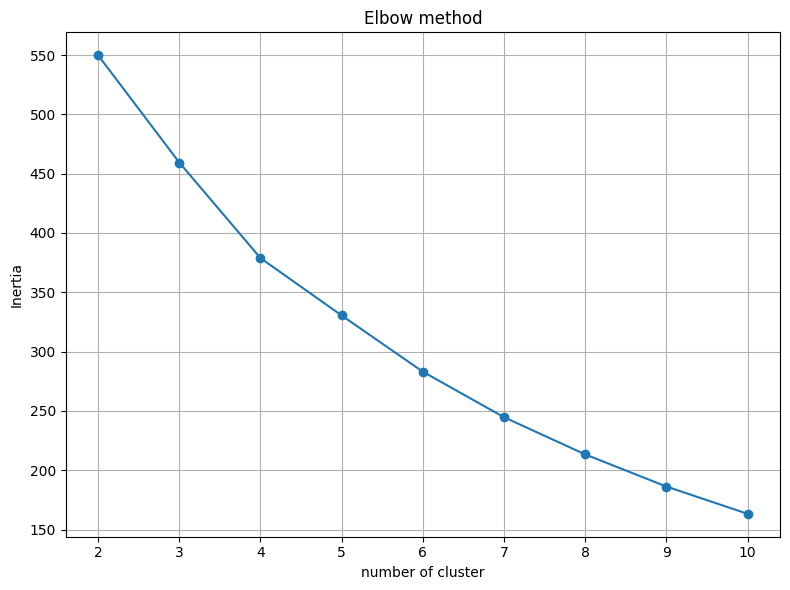

In [10]:
plt.figure(figsize=(8,6))
plt.plot(cluster_range, Inertia, marker='o')
plt.title("Elbow method")
plt.xlabel("number of cluster")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()


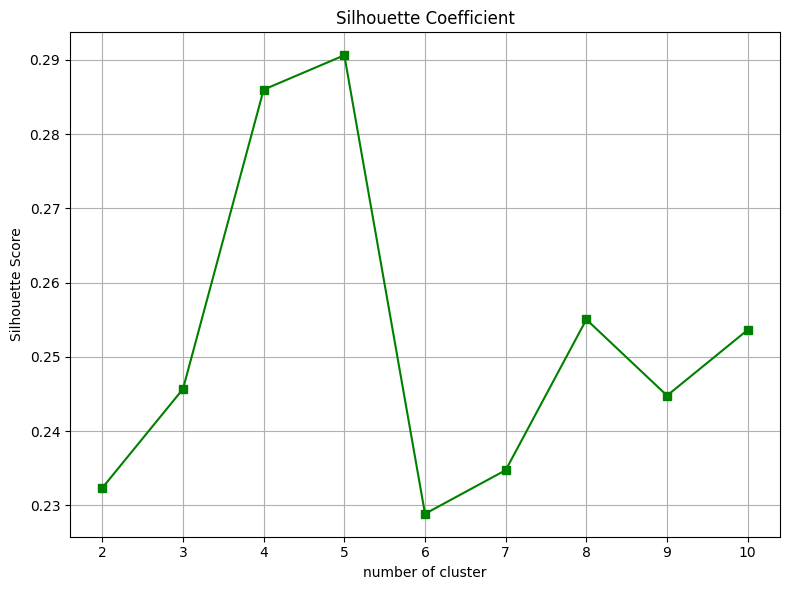

In [11]:
plt.figure(figsize=(8,6))
plt.plot(cluster_range, silhouette_scores, marker='s', color='green')
plt.title("Silhouette Coefficient")
plt.xlabel("number of cluster")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# 실루엣계수가 가장 높은 5로 클러스터 설정
grouped['계층_클러스터'] = fcluster(Z, t=5, criterion='maxclust')

In [42]:
# 클러스터별 업종명 빈도수 출력
cluster_industry = grouped.groupby('계층_클러스터')['서비스_업종_코드_명'].value_counts()

# 보기 쉽게 출력
for cluster_num, 업종 in cluster_industry.groupby(level=0):
    print(f"\n📌 클러스터 {cluster_num}에 포함된 업종들:")
    print(업종.droplevel(0).sort_values(ascending=False))



📌 클러스터 1에 포함된 업종들:
서비스_업종_코드_명
문구            1
컴퓨터및주변장치판매    1
Name: count, dtype: int64

📌 클러스터 2에 포함된 업종들:
서비스_업종_코드_명
가전제품수리    1
미곡판매      1
반찬가게      1
섬유제품      1
육류판매      1
의료기기      1
의약품       1
인테리어      1
자동차수리     1
조명용품      1
철물점       1
청과상       1
치과의원      1
한의원       1
Name: count, dtype: int64

📌 클러스터 3에 포함된 업종들:
서비스_업종_코드_명
스포츠 강습    1
예술학원      1
외국어학원     1
일반교습학원    1
Name: count, dtype: int64

📌 클러스터 4에 포함된 업종들:
서비스_업종_코드_명
가구              1
가방              1
가전제품            1
고시원             1
골프연습장           1
네일숍             1
노래방             1
당구장             1
미용실             1
부동산중개업          1
분식전문점           1
서적              1
세탁소             1
수산물판매           1
슈퍼마켓            1
스포츠클럽           1
시계및귀금속          1
신발              1
안경              1
애완동물            1
양식음식점           1
여관              1
완구              1
운동/경기용품         1
일반의류            1
일반의원            1
일식음식점           1
자동차미용           1
자전거 및 기타운송장비    1
전자상거래업          1
제과점   

In [24]:
cluster_profile = grouped.groupby('계층_클러스터')[
    ['weekday_ratio', 'weekend_ratio', 'male_ratio', 'female_ratio', 'unknown_ratio',
     '10s_ratio', '20s_ratio', '30s_ratio', '40s_ratio', '50s_ratio', '60_이상s_ratio']
].mean().round(3)


print(cluster_profile)

         weekday_ratio  weekend_ratio  male_ratio  female_ratio  \
계층_클러스터                                                           
1                0.899          0.101       0.324         0.191   
2                0.841          0.159       0.476         0.408   
3                0.868          0.132       0.405         0.581   
4                0.720          0.280       0.477         0.429   
5                0.645          0.355       0.820         0.180   

         unknown_ratio  10s_ratio  20s_ratio  30s_ratio  40s_ratio  50s_ratio  \
계층_클러스터                                                                         
1                0.485      0.004      0.052      0.086      0.152      0.140   
2                0.116      0.001      0.037      0.111      0.185      0.243   
3                0.015      0.002      0.056      0.169      0.537      0.184   
4                0.094      0.007      0.147      0.209      0.210      0.198   
5                0.001      0.078      0.532

In [15]:
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


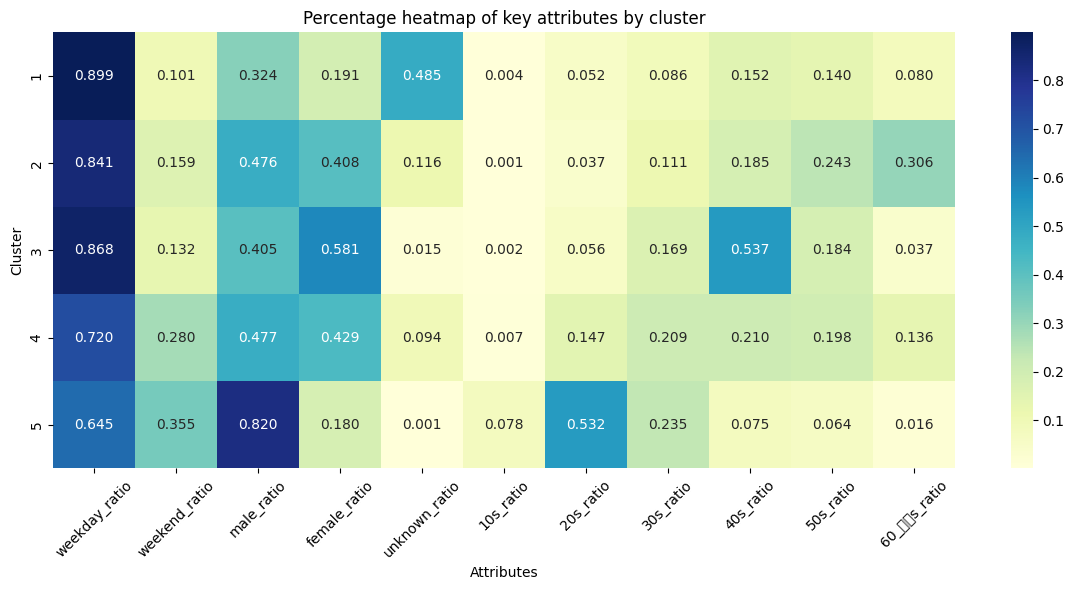

In [25]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_profile,       # 클러스터별 평균 데이터프레임
    annot=True,            # 숫자 표시
    fmt=".3f",             # 소수점 둘째 자리까지
    cmap="YlGnBu",         # 색상 테마 (연두~파랑 계열)
    cbar=True              # 오른쪽 색상바 표시
)
plt.title("Percentage heatmap of key attributes by cluster")
plt.ylabel("Cluster")
plt.xlabel("Attributes")
plt.xticks(rotation=45)    # x축 라벨 기울이기
plt.tight_layout()         # 자동 여백 조정
plt.show()
